In [1]:
import pandas as pd    # to create a dataframe from JSON datafile
import numpy as np     # to handle large python list as numpy arrays - makes the process faster. Used in creating dataFrame
import matplotlib.pyplot as plt # to draw plot - for visualization
from collections import Counter # to counter class distribution in the dataset
import re              # for data cleaning
import seaborn as sns  # for distribution plot
import pickle          # to save tokenizer
from keras import preprocessing

%matplotlib inline
from keras.preprocessing.text import Tokenizer # for converting words to numbers
from keras.preprocessing.sequence import pad_sequences # to pad sentences which are less than defined length
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, SpatialDropout1D, Input, Activation
from keras.models import Model
from sklearn.model_selection import train_test_split
#from keras.utils.np_utils import to_categorical

pd.set_option('max_colwidth', 300,"html.border",2)  # For aesthetic purposes
from IPython.display import display, HTML           # For aesthetic purposes

Using TensorFlow backend.


html.border has been deprecated, use display.html.border instead
(currently both are identical)



/Users/dinodjakovac/anaconda2/envs/gl-env/lib/python2.7/site-packages/pandas/core/config.py:619: FutureWarning: html.border has been deprecated, use display.html.border instead
(currently both are identical)

  warnings.warn(d.msg, FutureWarning)


In [2]:
df = pd.read_csv('https://s3-us-west-2.amazonaws.com/patchworks-coding-challenge/amazon_alexa.tsv', sep='\t')


In [3]:
c = Counter(df['rating'])
print (c)
print ("Percentage distribution of labels : ")
[(i, c[i] / len(df) * 100.0) for i in c]

Counter({5: 2286, 4: 455, 1: 161, 3: 152, 2: 96})
Percentage distribution of labels : 


[(1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0)]

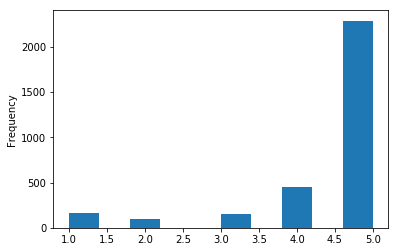

In [4]:
df['rating'].plot.hist()
plt.show()

In [5]:
df = df.reindex(np.random.permutation(df.index)).reset_index(drop=True)
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,30-Jul-18,Black Plus,Great sound and easy to set up. Purchased the Echo Plus because it had a built in Hub and would make it easier to connect to devices. I am hooked on Alexa!,1
1,5,30-Jul-18,Charcoal Fabric,"My Android would not allow Alexa to connect. Fortunately, my sister was here with her Apple cell. After an hour+ tech support fixed the glitches. We are up and running.",1
2,2,24-Jul-18,Black Spot,ALEXA IS NOT AS SMART AS SIRI! CANNOT CANCEL SNOOZE AFTER ALARM GOES OFF. HAVE TO CANCEL PRE-SET ALARM FOR WEEKDAYS.,0
3,5,11-Jul-18,Black,Simple set up. Music everywhere.,1
4,5,30-Jul-18,Black Spot,Couldn't be more pleased. Amazon hit this one out of the park. Looks great and runs great. Love it!,1


In [7]:
negative1 = df[df["rating"]==1].head(96)
negative2 = df[df["rating"]==2].head(96)

positive1 = df[df["rating"]==4].head(96)
positive2 = df[df["rating"]==5].head(96)

del df   # freeing up memory

df = pd.DataFrame()
df = df.append(negative1)
df = df.append(negative2)
df = df.append(positive1)
df = df.append(positive2)

del negative1
del negative2
del positive1
del positive2

df = df.reindex(np.random.permutation(df.index)).reset_index(drop=True)
df.head()

,rating,date,variation,verified_reviews,feedback
0,1,29-Jul-18,Black Show,Returned from repair with No repair done. It has a problem which requires it to be on for a while for the defective part to show itself.I sent it for repair and got it back without being fixed. The site gives no option to complain from the page.I have a echo spot which works perfectly in the sa...,0
1,4,30-Jul-18,Black Dot,I bought the echo dot while it was on sale for prime day and I was excited when it came in the next day. I set it up immediately and everything worked perfectly fine. The set up was easy and straight forward which I really appreciated because I am terrible with technology. The only reason why I ...,1
2,2,30-Jul-18,Configuration: Fire TV Stick,"Had to return it as Hulu does not work on device. It kept coming up with errors, and Hulu app not being able to open at times. It was hit and miss, and at times, Hulu will stop working right in the middle of a show or movie. Plus fire stick is very slow in opening the apps.",0
3,2,29-Jul-18,Sandstone Fabric,It's got great sound and bass but it doesn't work all of the time. Its still hot or miss when it recognizes things,0
4,5,27-Jul-18,Black Plus,The echo plus is very straight forward and easy to use. It plays great sounding music and can do lots of other things. Still learning what all it can do. Working very well so far.,1


In [8]:
df.describe()

,rating,feedback
count,384.000000,384.000000
mean,3.000000,0.500000
std,1.583202,0.500652
min,1.000000,0.000000
25%,1.750000,0.000000
50%,3.000000,0.500000
75%,4.250000,1.000000
max,5.000000,1.000000


In [10]:
df['verified_reviews'] = df['verified_reviews'].apply(lambda x:re.sub(r'\W+', " ",x))
df['verified_reviews'] = df['verified_reviews'].apply(lambda x:x.lower())

df['rating']  = df['rating'].apply(lambda x: 0 if (x==1 or x==2) else 1)
df.head()

,rating,date,variation,verified_reviews,feedback
0,1,29-Jul-18,Black Show,returned from repair with no repair done it has a problem which requires it to be on for a while for the defective part to show itself i sent it for repair and got it back without being fixed the site gives no option to complain from the page i have a echo spot which works perfectly in the same ...,0
1,0,30-Jul-18,Black Dot,i bought the echo dot while it was on sale for prime day and i was excited when it came in the next day i set it up immediately and everything worked perfectly fine the set up was easy and straight forward which i really appreciated because i am terrible with technology the only reason why i am ...,1
2,1,30-Jul-18,Configuration: Fire TV Stick,had to return it as hulu does not work on device it kept coming up with errors and hulu app not being able to open at times it was hit and miss and at times hulu will stop working right in the middle of a show or movie plus fire stick is very slow in opening the apps,0
3,1,29-Jul-18,Sandstone Fabric,it s got great sound and bass but it doesn t work all of the time its still hot or miss when it recognizes things,0
4,0,27-Jul-18,Black Plus,the echo plus is very straight forward and easy to use it plays great sounding music and can do lots of other things still learning what all it can do working very well so far,1


In [13]:
def countWords(sentences):
    """
    Function to count number of words in each sentence from the given list of sentences
    :param sentences : List(String). List of sentences
    :return: List(Integer). List of number of words in each sentence
    """
    countWords = []
    words = []
    for sentence in sentences:
        countWords.append(len(sentence.split(" ")))
        words.extend(sentence.split(" "))
        
    return countWords[:], words

numberOfWords, words = countWords(df['verified_reviews'].values[:])
print (numberOfWords[:20])

[62, 140, 59, 25, 36, 99, 103, 15, 37, 6, 17, 31, 64, 97, 8, 4, 15, 4, 2, 3]


In [14]:
# Complete this part of the code
c = Counter(words)  # Note : 'words' in defined in below cell under 'Standardize text'. Run that cell first
print ("Total number of words in corpus : ", len(c))

('Total number of words in corpus : ', 1958)


In [15]:
max_fatures = 2000
# df = pd.read_csv("../data/subset_dataset")

tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df['verified_reviews'].values)

/Users/dinodjakovac/anaconda2/envs/gl-env/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


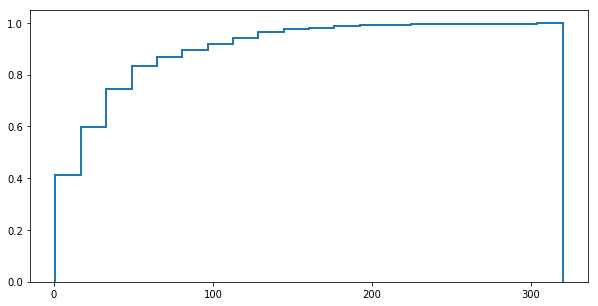

In [17]:
plt.figure(figsize=(10,5))
# plt.title("Cumulative distribution of number of words per sentence")
plt.xticks(np.arange(0, max(numberOfWords)+1, 100.0))
plt.hist(numberOfWords,normed=1,cumulative=True, histtype='step', bins = 20, linewidth=2)
plt.show()

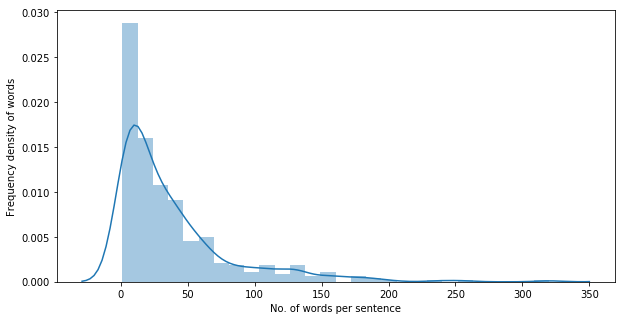

In [18]:
plt.figure(figsize=(10,5))
plt.xlabel("No. of words per sentence")
plt.ylabel("Frequency density of words")
sns.distplot(numberOfWords)
plt.show()

In [19]:
df_class = df
X = df_class['verified_reviews']
y = df_class['rating']

In [20]:
from sklearn.model_selection import train_test_split


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)


In [22]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [25]:
nb.fit(X_train, y_train)


ValueError: could not convert string to float: was loving it but starting in june hulu stopped working and crunchyroll doesn t work either probably will switch to something else soon 

In [24]:
preds = nb.predict(X_test)


NotFittedError: This MultinomialNB instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.